# HiddenLayer Training Demo - TensorFlow

In [1]:
import os
import time
import random
import numpy as np
import tensorflow as tf
import hiddenlayer as hl

## Basic Use Case

To track your training, you need to use two Classes: History to store the metrics, and Canvas to draw them.
This example simulates a training loop.

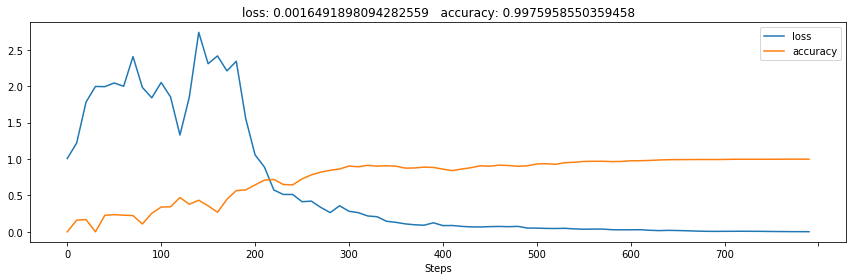

In [2]:
# A History object to store metrics
history1 = hl.History()

# A Canvas object to draw the metrics
canvas1 = hl.Canvas()

# Simulate a training loop with two metrics: loss and accuracy
loss = 1
accuracy = 0
for step in range(800):
    # Fake loss and accuracy
    loss -= loss * np.random.uniform(-.09, 0.1)
    accuracy = max(0, accuracy + (1 - accuracy) * np.random.uniform(-.09, 0.1))

    # Log metrics and display them at certain intervals
    if step % 10 == 0:
        # Store metrics in the history object
        history1.log(step, loss=loss, accuracy=accuracy)

        # Plot the two metrics in one graph
        canvas1.draw_plot([history1["loss"], history1["accuracy"]])

        time.sleep(0.1)

## Comparing Experiments

Often you'd want to compare how experiments compare to each other. 

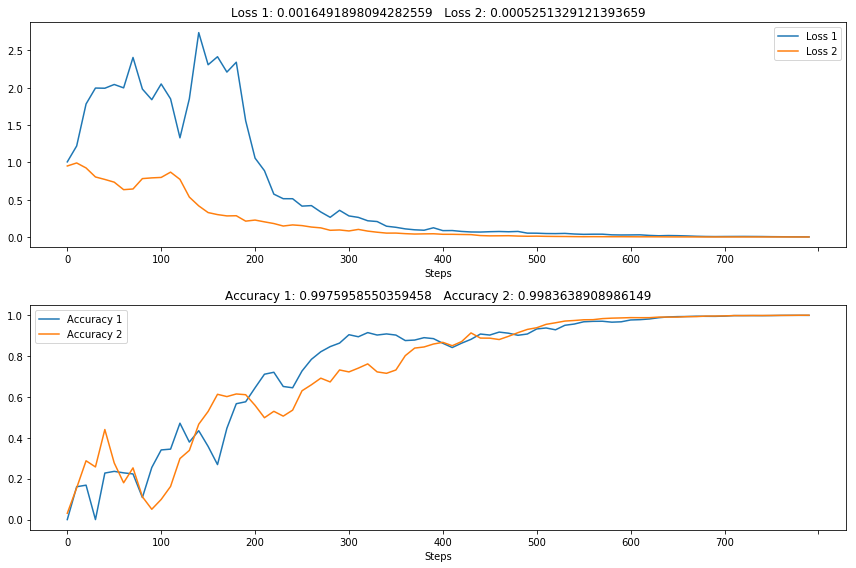

In [3]:
# New history and canvas objects
history2 = hl.History()
canvas2 = hl.Canvas()

# Simulate a training loop with two metrics: loss and accuracy
loss = 1
accuracy = 0
for step in range(800):
    # Fake loss and accuracy
    loss -= loss * np.random.uniform(-.09, 0.1)
    accuracy = max(0, accuracy + (1 - accuracy) * np.random.uniform(-.09, 0.1))

    # Log metrics and display them at certain intervals
    if step % 10 == 0:
        history2.log(step, loss=loss, accuracy=accuracy)

        # Draw two plots
        # Encluse them in a "with" context to ensure they render together
        with canvas2:
            canvas2.draw_plot([history1["loss"], history2["loss"]],
                              labels=["Loss 1", "Loss 2"])
            canvas2.draw_plot([history1["accuracy"], history2["accuracy"]],
                              labels=["Accuracy 1", "Accuracy 2"])
        time.sleep(0.1)

## Saving and Loading Histories

The History object store the metrics in RAM, which is often good enough for simple 
expriments. To keep the history, you can save/load them with.

In [4]:
# Save experiments 1 and 2
history1.save("experiment1.pkl")
history2.save("experiment2.pkl")

In [5]:
# Load them again. To verify it's working, load them into new objects.
h1 = hl.History()
h2 = hl.History()
h1.load("experiment1.pkl")
h2.load("experiment2.pkl")

Verify the data is loaded

In [6]:
# Show a summary of the experiment
h1.summary()

Last Step: 790
Training Time: 0:00:29.004116


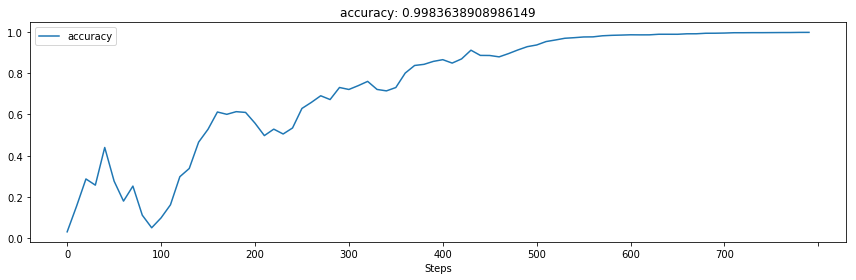

In [7]:
# Draw a plot of experiment 2
hl.Canvas().draw_plot(h2["accuracy"])

## Custom Visualizations

Adding new custom visualizations is pretty easy. Derive a new class from `Canvas` and add your new method to it. You can use any of the drawing functions provided by `matplotlib`.

Here is an example to display the accuracy metric as a pie chart.

In [8]:
class MyCanvas(hl.Canvas):
    """Extending Canvas to add a pie chart method."""
    
    def draw_pie(self, metric):
        # Method name must start with 'draw_' for the Canvas to automatically manage it
        
        # Use the provided matplotlib Axes in self.ax
        self.ax.axis('equal')  # set square aspect ratio

        # Get latest value of the metric
        value = np.clip(metric.data[-1], 0, 1)
        
        # Draw pie chart
        self.ax.pie([value, 1-value], labels=["Accuracy", ""])

In addition to the pie chart, let's use image visualizations (which is built-in).

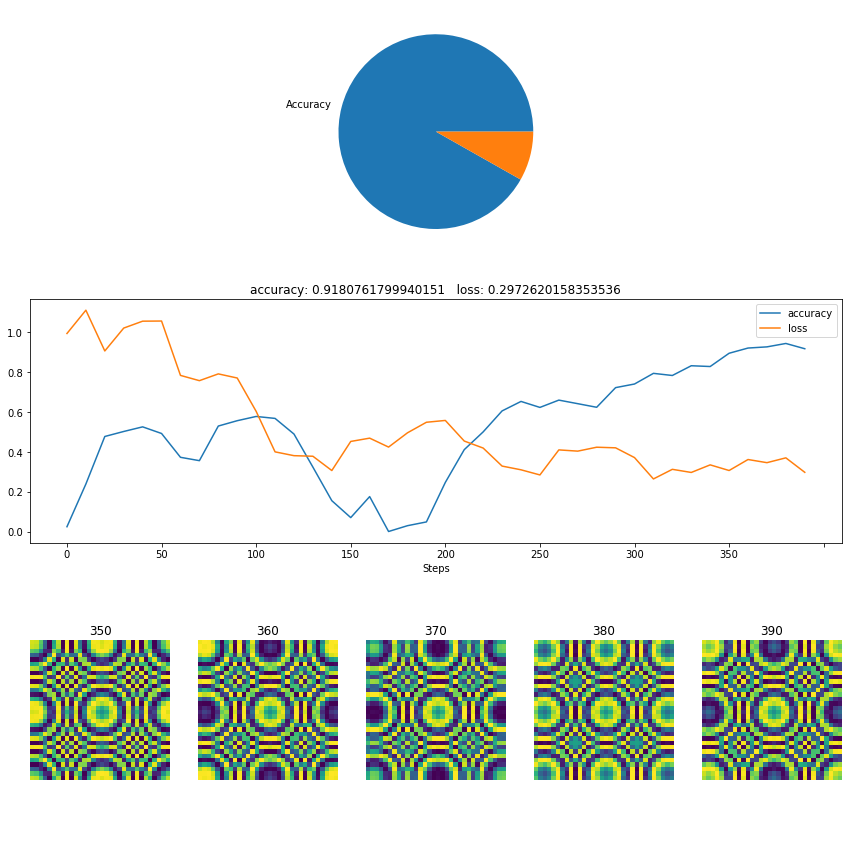

In [9]:
history3 = hl.History()
canvas3 = MyCanvas()  # My custom Canvas

# Simulate a training loop
loss = 1
accuracy = 0
for step in range(400):
    # Fake loss and accuracy
    loss -= loss * np.random.uniform(-.09, 0.1)
    accuracy = max(0, accuracy + (1 - accuracy) * np.random.uniform(-.09, 0.1))

    if step % 10 == 0:
        # Log loss and accuracy
        history3.log(step, loss=loss, accuracy=accuracy)

        # Log a fake image metric (e.g. image generated by a GAN)
        image = np.sin(np.sum(((np.indices([32, 32]) - 16) * 0.5 * accuracy) ** 2, 0))
        history3.log(step, image=image)
        
        # Display
        with canvas3:
            canvas3.draw_pie(history3["accuracy"])
            canvas3.draw_plot([history3["accuracy"], history3["loss"]])
            canvas3.draw_image(history3["image"])

        time.sleep(0.1)

## Running without a GUI

If the training loop is running on a server without a GUI, then use the `History` `progress()` method to print a text status.

In [10]:
# Print the metrics of the last step.
history1.progress()

Step 790: loss: 0.0016491898094282559  accuracy: 0.9975958550359458  


You can also periodically saving a snapshot of the graphs to disk to view later. See `demos/history_demo.py` for an example.

First, set matplotlib backend to Agg.
```Python
# Set matplotlib backend to Agg. MUST be done BEFORE importing hiddenlayer
import matplotlib
matplotlib.use("Agg")
```

Then, in the training loop:
```
    # Print a text progress status in the loop
    history.progress()

    # Occasionally, save a snapshot of the graphs.
    canvas.draw_plot([h["loss"], h["accuracy"]])
    canvas.save("training_graph.png")
```

## Real Training Example

In [11]:
# Import the model code
from tf_cifar10 import CIFAR10

# Create data directory in project root (to download dataset to)
ROOT_DIR = os.path.dirname(os.path.abspath(os.getcwd()))
DATA_DIR = os.path.join(ROOT_DIR, "test_data")

In [17]:
# CIFAR10 dataset and model
batch_size = 50
cifar10 = CIFAR10(batch_size=batch_size, data_dir=DATA_DIR)

In [18]:
# Inspect data and labels
hl.write("cifar10.train_data", cifar10.train_data)
hl.write("cifar10.train_labels", cifar10.train_labels)
hl.write("cifar10.test_data", cifar10.test_data)
hl.write("cifar10.test_labels", cifar10.test_labels)

cifar10.train_data	Tensor  float64 (50000, 32, 32, 3)  min: 0.000  max: 1.000
cifar10.train_labels	Tensor  float64 (50000, 10)  min: 0.000  max: 1.000
cifar10.test_data	Tensor  float64 (10000, 32, 32, 3)  min: 0.000  max: 1.000
cifar10.test_labels	Tensor  float64 (10000, 10)  min: 0.000  max: 1.000


In [19]:
# Build the TensorFlow Graph
tf_graph = tf.Graph()

with tf_graph.as_default():
    # Placeholders
    inputs = tf.placeholder(
        tf.float32, 
        shape=(batch_size, cifar10.img_size, cifar10.img_size, cifar10.num_channels))
    outputs = tf.placeholder(tf.float32, shape=[batch_size, cifar10.num_classes])
    # Build model
    predictions = cifar10.model(inputs)

    # Loss and optimizer
    loss_op = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
        logits=predictions, labels=outputs))
    optimizer = tf.train.MomentumOptimizer(
        learning_rate=0.01, momentum=0.9).minimize(loss_op)

    # Metrics
    accurate_preds = tf.equal(tf.argmax(predictions, axis=1), tf.argmax(outputs, axis=1))
    accuracy_op = tf.reduce_mean(tf.cast(accurate_preds, tf.float32))

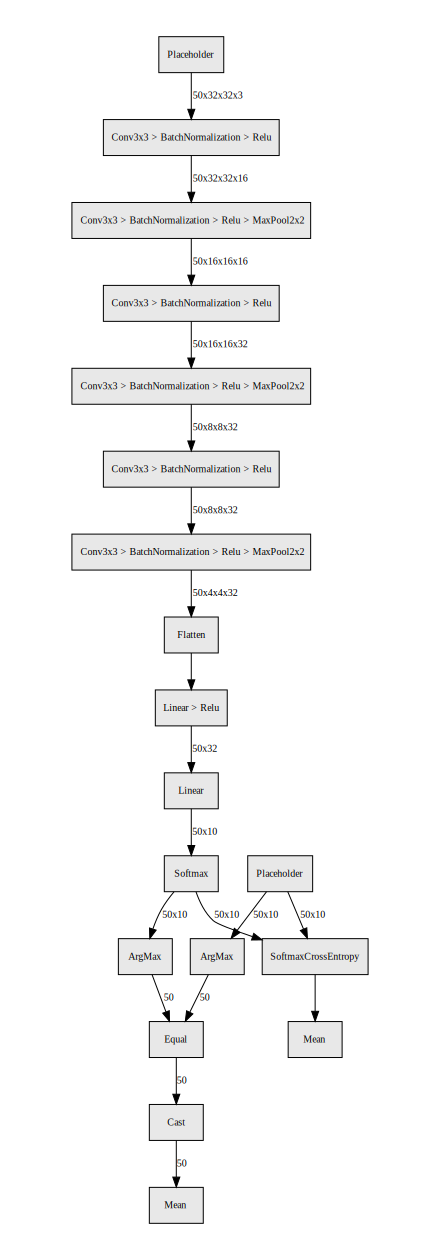

In [20]:
# Display graph
hl.build_graph(tf_graph)

## Visualize Training Progress

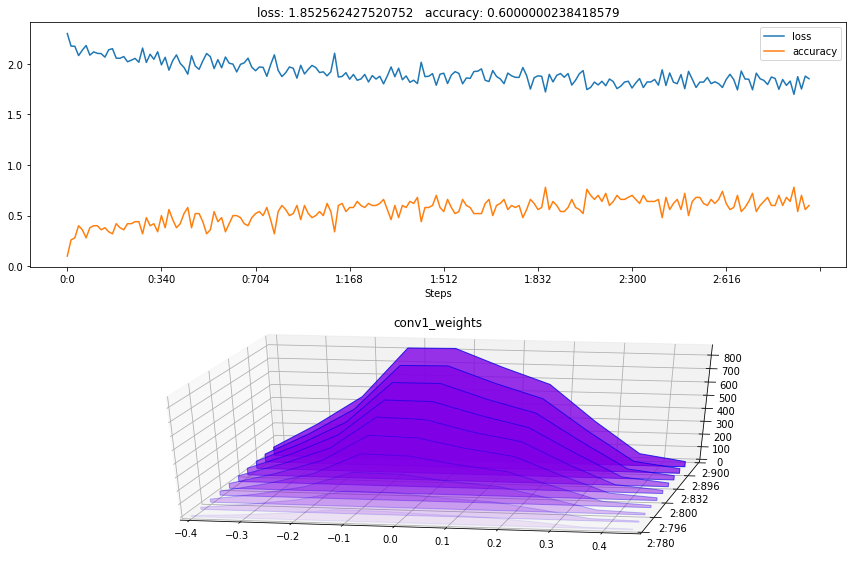

In [21]:
# Run training loop for a few epochs
with tf_graph.as_default():
    # Instantiate history and canvas
    cifar_history = hl.History()
    cifar_canvas = hl.Canvas()

    # Setup TF training session
    sess = tf.Session()
    
    # Run the initializer
    sess.run(tf.global_variables_initializer())

    for epoch in range(3):
        batches, _ = divmod(cifar10.train_len, batch_size)
        for batch in range(batches):
            # Fetch training samples
            _input = cifar10.train_data[batch*batch_size : (batch+1)*batch_size]
            _output = cifar10.train_labels[batch*batch_size : (batch+1)*batch_size]

            # Train
            _, loss, accuracy = sess.run([optimizer, loss_op, accuracy_op], 
                                         feed_dict={inputs : _input, outputs : _output})

            # Print stats
            if batch & batch % 100 == 0:
                # Log metrics: loss, accuracy, and one weights matrix
                conv1_weights = tf_graph.get_tensor_by_name('conv1/conv2d/kernel:0').eval(session=sess)
                cifar_history.log((epoch, batch),
                                  loss=loss,
                                  accuracy=accuracy,
                                  conv1_weights=conv1_weights)
                # Display graphs
                with cifar_canvas:
                    cifar_canvas.draw_plot([cifar_history["loss"], cifar_history["accuracy"]])
                    cifar_canvas.draw_hist(cifar_history["conv1_weights"])